In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# **Data Preperation**

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [5]:
X_train = [] #For Images
y_train = [] #For storing labels
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/apple/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:38<00:00,  1.90it/s]


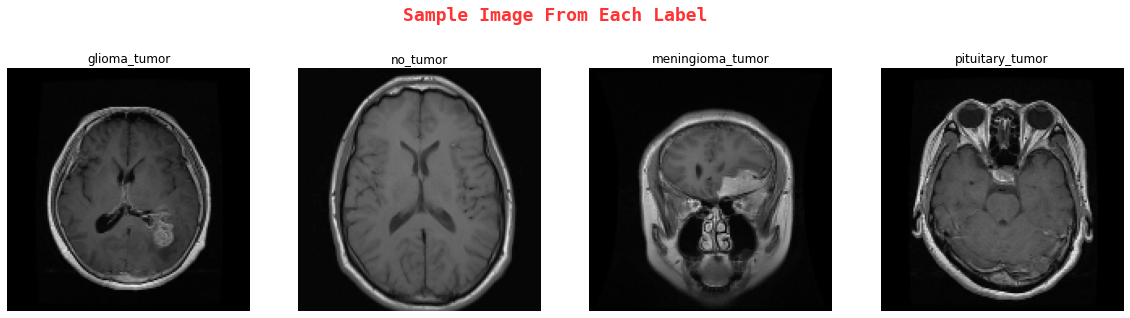

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [10]:
print("Lenght of test dataset is:",len(X_test) )
print("Lenght of test dataset is:",len(X_train) )
total=len(X_test)+len(X_train)
print("Total images are",total)
ratio=len(X_train)/total
train_ratio=ratio*100
test_ratio=(len(X_test)/total)*100
print("the ratio of test train split is",round(train_ratio),":",round(test_ratio))


Lenght of test dataset is: 653
Lenght of test dataset is: 2611
Total images are 3264
the ratio of test train split is 80 : 20


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


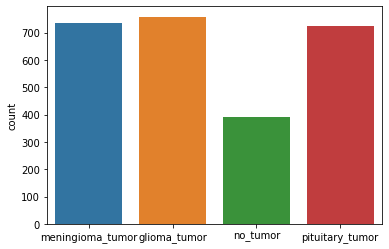

In [12]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


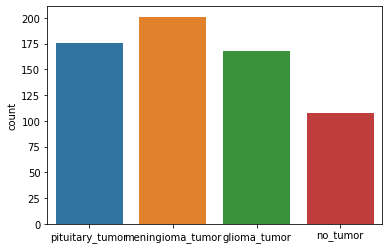

In [13]:
sns.countplot(y_test)

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
from glob import glob 
folders = glob('Training/*')

# **Transfer Learning**

In [16]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

31801344/31790344 [==============================] - 0s 0us/step


In [17]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
x = Flatten()(effnet.output)

In [18]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import base64
import io

In [36]:
model = Sequential()
inputShape = (150, 150, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (150, 150, 3)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation("softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        1

In [21]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [22]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# **Training The Model**

In [23]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 1.2606 - accuracy: 0.6113
Epoch 1: val_accuracy improved from -inf to 0.35878, saving model to effnet.h5
74/74 [==============================] - 51s 677ms/step - loss: 1.2606 - accuracy: 0.6113 - val_loss: 1.9724 - val_accuracy: 0.3588 - lr: 0.0010
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.7497
Epoch 2: val_accuracy improved from 0.35878 to 0.64122, saving model to effnet.h5
74/74 [==============================] - 50s 678ms/step - loss: 0.7304 - accuracy: 0.7497 - val_loss: 0.8904 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.8029
Epoch 3: val_accuracy improved from 0.64122 to 0.76336, saving model to effnet.h5
74/74 [==============================] - 50s 671ms/step - loss: 0.5565 - accuracy: 0.8029 - val_loss: 0.6044 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 4/20
74/74 [======================

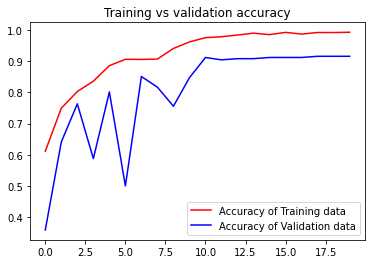

<Figure size 432x288 with 0 Axes>

In [24]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

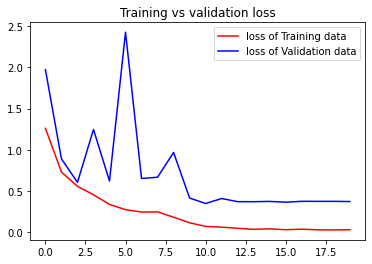

<Figure size 432x288 with 0 Axes>

In [25]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# **Prediction**

In [26]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

# **Evaluation**

In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       168
           1       0.96      0.88      0.92       108
           2       0.91      0.88      0.89       201
           3       0.94      1.00      0.97       176

    accuracy                           0.92       653
   macro avg       0.93      0.92      0.92       653
weighted avg       0.93      0.92      0.92       653



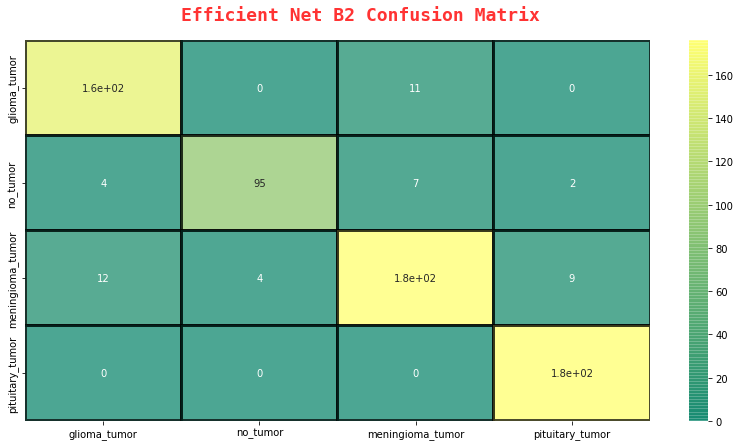

In [28]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap='summer',alpha=0.7,linewidths=2,linecolor='black')
fig.text(s='Efficient Net B2 Confusion Matrix ',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [29]:
from tensorflow.keras.models import load_model

model.save('efficient_b2.h5')

In [30]:
pred

array([3, 2, 0, 1, 3, 2, 2, 3, 2, 2, 2, 0, 0, 1, 2, 3, 3, 2, 3, 1, 3, 0,
       1, 1, 1, 3, 2, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 2, 2, 3, 2,
       2, 3, 0, 0, 3, 0, 2, 0, 3, 3, 2, 3, 0, 3, 2, 0, 2, 2, 1, 0, 3, 3,
       3, 0, 2, 0, 0, 0, 3, 1, 0, 2, 0, 0, 2, 0, 2, 2, 3, 3, 0, 0, 2, 2,
       2, 1, 1, 3, 1, 2, 0, 2, 0, 2, 3, 2, 2, 0, 2, 2, 1, 3, 3, 0, 0, 2,
       2, 2, 3, 0, 3, 0, 3, 3, 2, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 0,
       1, 3, 2, 0, 3, 3, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 2, 3, 1, 2, 3,
       2, 3, 1, 1, 0, 2, 3, 2, 1, 2, 0, 0, 0, 1, 0, 0, 3, 3, 3, 1, 2, 3,
       0, 0, 3, 0, 3, 0, 1, 0, 3, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1,
       2, 2, 3, 0, 3, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 0, 0, 3, 0, 0, 3, 0,
       2, 1, 3, 1, 3, 0, 1, 3, 3, 3, 0, 0, 3, 0, 0, 2, 3, 3, 0, 0, 3, 0,
       3, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 3, 1, 3, 3, 0, 3, 3, 1,
       0, 0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 3, 2, 0, 0, 1, 3, 1, 3, 3, 1, 2,
       0, 1, 1, 0, 2, 2, 2, 3, 3, 0, 3, 0, 0, 3, 0,

In [31]:
pred=pred.flatten().astype(int)

In [32]:
y_test_new=y_test_new.flatten().astype(int)

In [33]:
df = pd.DataFrame({'Actual': y_test_new, 'Predicted': pred})

In [34]:
df.head(10)

,Actual,Predicted
0,3,3
1,2,2
2,0,0
3,1,1
4,3,3
5,2,2
6,2,2
7,3,3
8,2,2
9,2,2
